# IMPORTS

In [1]:
from hvac_control.data import load_data
from hvac_control.preprocessing import *
import pandas as pd

#load preprocessed data
data_to_load = "gaia_data_1.csv"
df_index = load_data(data_to_load, data_type='interim', header_names=None, index=True)
print(df_index.shape)
df_index.head()

(15862, 12)


,T_ext,Solar_irrad,T_imp,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow,T_ret
datetime,,,,,,,,,,,,
2022-05-18 00:02:00+00:00,19.450001,0.0,15.040009,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.320007
2022-05-18 00:04:00+00:00,19.450001,0.0,15.070007,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.320007
2022-05-18 00:06:00+00:00,19.450001,0.0,14.980011,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.260010
2022-05-18 00:08:00+00:00,19.510000,0.0,15.040009,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.260010
2022-05-18 00:10:00+00:00,19.510000,0.0,15.110001,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.275009


# PREPROCESSING

Use only weekday data from a cleaned dataframe (weekends removed)

In [2]:
dfs_weekdays = remove_weekends(df_index)
df_weekdays= pd.concat(dfs_weekdays)
print(df_weekdays.shape)

(11542, 12)


Use only data from a cleaned dataframe (non working hours and weird days removed)

In [3]:
df_working = remove_specific_day(df_index, '2022-05-25')
dfs_working = remove_non_working_hours(df_working, strating_hour='05:00', ending_hour='17:30')
df_working= pd.concat(dfs_working)
print(df_working.shape)

(5640, 15)


# SOM

## Remove non linear columns

In [4]:
x_columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'BC1_flow', 'BC2_flow', 
           'Refr2_flow']

y_column = ['T_ret']

all_columns = x_columns + y_column

df_to_study = df_working.copy()
df_to_study = df_to_study[all_columns]
print(list(df_to_study.columns))

['T_ext', 'Solar_irrad', 'T_imp', 'BC1_power', 'BC2_power', 'Refr1_power', 'BC1_flow', 'BC2_flow', 'Refr2_flow', 'T_ret']


## Split

We will use `all_columns` for training (there will not be a y dataset because there isn't a target we want to predict here)

In [5]:
from sklearn.model_selection import train_test_split

X=df_to_study[all_columns].to_numpy()

# train and test split
train_x, test_x = train_test_split(X, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('x test shape: ', test_x.shape)


x train shape:  (4512, 10)
x test shape:  (1128, 10)


## Scale

In [6]:
from hvac_control.preprocessing import minmax_scaler_given_parameters, std_scaler_given_parameters

max_val = train_x.max()
min_val = train_x.min()
mu = train_x.mean(0)
s = train_x.std(0)

#train_x_norm = minmax_scaler_given_parameters(train_x, min_val, max_val)
#test_x_norm = minmax_scaler_given_parameters(test_x, min_val, max_val)

train_x_norm = std_scaler_given_parameters(train_x, mu, s)
test_x_norm = std_scaler_given_parameters(test_x, mu, s)

## Training

Using my implementation

In [7]:
from hvac_control.som import SOM

model=SOM(som_grid_size=(12,12),
          max_distance=6,
          learning_rate_0=0.5,
          max_iter=100000,
          random_state=0,
          sigma_0=1, 
          sigma_decay=0.0005,
          learning_rate_decay=0.0005,
          methods={'init_som': 'uniform',
                  'bmu_distance': 'cityblock',
                  'compute_neighborhood': 'ceil',
                  'update_sigma_and_learning_rate': 'linear'}) 
model=model.fit(train_x_norm, epochs=8)
som=model.som
som_dataset=som.reshape(-1,som.shape[2])

Using minisom implementation (might need to be installed with pip)

In [8]:
# from minisom import MiniSom    
# model2 = MiniSom(20, 20, 11, sigma=2, learning_rate=.5, 
#                  neighborhood_function='gaussian', 
#                  topology='rectangular',
#                  activation_distance='euclidean', 
#                  random_seed=None) 
# model2.train(train_x_norm, 20000) 
# som2=model2.get_weights()
# som_dataset=som2.reshape(-1,som2.shape[2])

PCA to show the results (there should be an overlap between the training data and the som weights)

SOM data 2D: Total = 0.6957590483515336 and per components = [0.50728193 0.18847711]
Train data 2D: Total = 0.5411397511320999 and per components = [0.37077567 0.17036408]


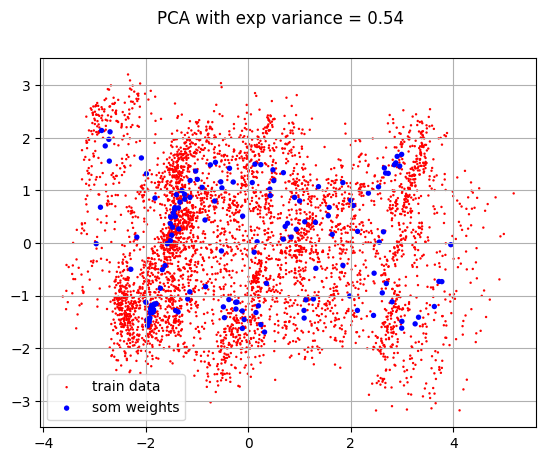

quantization error =  1.421221830547622


In [9]:
from sklearn.decomposition import PCA
from hvac_control.som_metrics import SOMmetrics
import matplotlib.pyplot as plt

# 2D vizualization
pca = PCA(n_components = 2)
pca_som = pca.fit_transform(som_dataset)

# Amount of explained variance kept 2D
exp_variance_2d = pca.explained_variance_ratio_
print(f"SOM data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# 3D vizualization
pca_train = pca.fit_transform(train_x_norm)
exp_variance_2d = pca.explained_variance_ratio_
print(f"Train data 2D: Total = {np.sum(exp_variance_2d)} and per components = {exp_variance_2d}")

# Plot of the 2D PCA results
fig, ax = plt.subplots()

ax.scatter(pca_train[:,0], pca_train[:,1], color="red", label="train data", edgecolors='none', s=3)
ax.scatter(pca_som[:,0], pca_som[:,1], color="blue", label="som weights", edgecolors='none', s=15)
ax.legend()
ax.grid(True)
fig.suptitle(f"PCA with exp variance = {round(np.sum(exp_variance_2d), 2)}")
plt.show()

metrics=SOMmetrics(model.som)
print('quantization error = ',metrics.quantization_error(train_x_norm, som))

# NOVELTY DETECTION

The first novelty detection method uses KNN. The lower the output metric, the better. A threshold is established in order to decide if the sample is an anomaly or not based on the metric value.

[array([ 74, 566, 604, 689, 907], dtype=int64)]


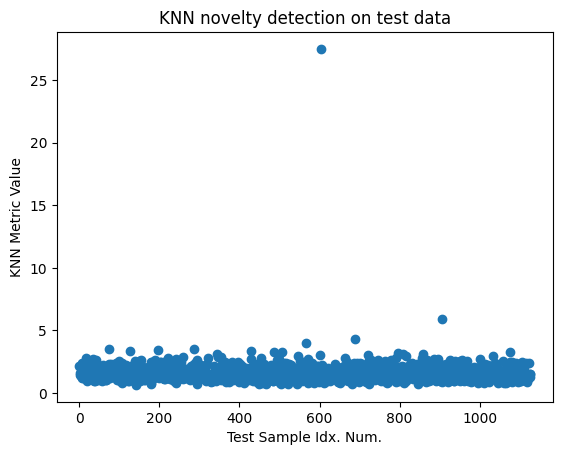

In [10]:
from hvac_control.som_novelty import KNN

thresh=3.5
model3=KNN(som,
          min_number_per_bmu=1,
          number_of_neighbors=3)

metric_knn=model3.evaluate(test_x_norm)
plt.scatter(np.arange(test_x_norm.shape[0]), metric_knn)
plt.title("KNN novelty detection on test data")  
plt.xlabel("Test Sample Idx. Num.")          
plt.ylabel("KNN Metric Value")          

print(list(np.where(metric_knn>thresh)))

The second novelty detection method uses a metric based on quantization error (Eq). Eq equal or less than the mean quantization error resulting from the SOM training process, Ēq, is associated with a metric of 0, whereas an Eq bigger than the distance between the two further matching units, dmax, represents a metric value of 1. Finally, a Eq bigger than Ēq, and lower than dmax, will result in a metric value between 0 and 1. 

[array([566, 604, 689, 907], dtype=int64)]


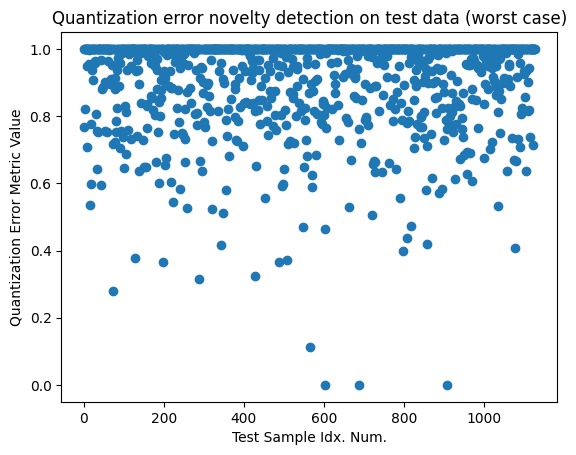

In [11]:
from hvac_control.som_novelty import Quantization_Error

thresh=0.25
model1=Quantization_Error(som, 'worst')
metric_eq1=model1.evaluate(train_x_norm, test_x_norm)
plt.scatter(np.arange(test_x_norm.shape[0]), metric_eq1)
plt.title("Quantization error novelty detection on test data (worst case)")  
plt.xlabel("Test Sample Idx. Num.")          
plt.ylabel("Quantization Error Metric Value")  

print(list(np.where(metric_eq1<thresh)))

Works the same as the method below but dmax is computed differently. Now dmax is not the distance between the two furthest matching units. Instead, it is is calculated locally for each neuron based on the distribution of the data points it has captured, hence every neuron (position in the SOM map) will have a different dmax. This method is more restrictive and will classify a larger number of samples as anomalies.

[array([   7,   18,   42,   74,   79,  105,  127,  138,  197,  202,  222,
        241,  254,  259,  309,  320,  321,  344,  429,  453,  487,  495,
        498,  507,  542,  550,  566,  583,  604,  627,  664,  689,  705,
        797,  817,  858,  869,  895,  907,  927,  958,  969,  985, 1034,
       1075], dtype=int64)]


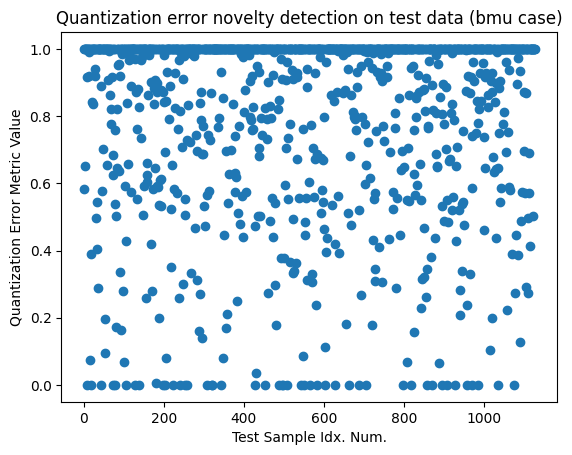

In [12]:
thresh=0.0001
model2=Quantization_Error(som, 'by_bmu')
metric_eq2=model2.evaluate(train_x_norm, test_x_norm)
plt.scatter(np.arange(test_x_norm.shape[0]), metric_eq2)
plt.title("Quantization error novelty detection on test data (bmu case)")  
plt.xlabel("Test Sample Idx. Num.")          
plt.ylabel("Quantization Error Metric Value") 

print(list(np.where(metric_eq2<thresh)))

Comparison of the metrics of both Quantization Error methods. As it is expected, when one sample is associated with a value of 1 in one case, the other case should have the same value. However, since the bmu case is more restrictive, it will give to more samples a value of 0, and generally, lower values of the metric.

Text(0, 0.5, 'BMU case metric value')

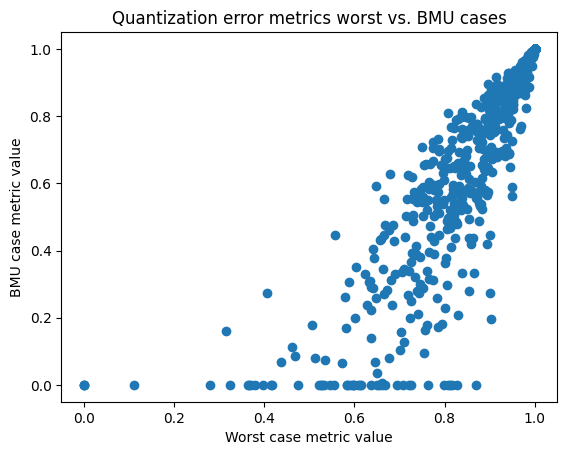

In [13]:
plt.scatter(metric_eq1, metric_eq2)
plt.title("Quantization error metrics worst vs. BMU cases")  
plt.xlabel("Worst case metric value")          
plt.ylabel("BMU case metric value") 

Comparison of the metrics of KNN and Quantization Error methods. We can observe that when KNN metric is low, the Quantization Error metric is high and close or equal to 1. 

Text(0, 0.5, 'Quantization Error metric value')

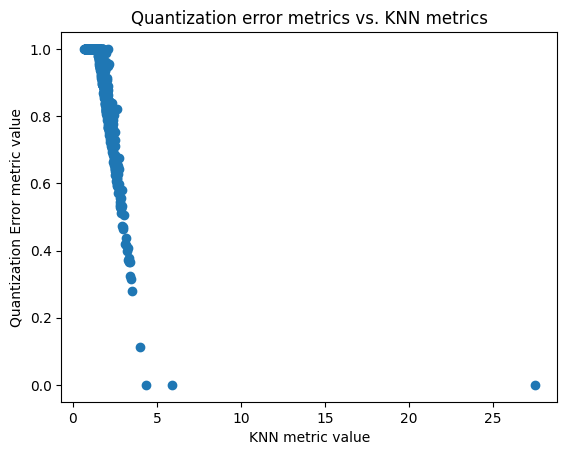

In [14]:
plt.scatter(metric_knn, metric_eq1)
plt.title("Quantization error metrics vs. KNN metrics")  
plt.xlabel("KNN metric value")          
plt.ylabel("Quantization Error metric value") 

# Reverse engineering

In [15]:
outlier_idx = 604
row = test_x[outlier_idx, :]
row

array([  18.05999947,  104.        ,    9.64001465,    3.15      ,
         15.55      ,   14.55      , 2707.        , 2577.        ,
          0.        ,   10.45999146])

In [16]:
diff_df = df_to_study - row
norm_df = diff_df.apply(np.linalg.norm, axis=1)
row_match = df_to_study.loc[norm_df.idxmin()]

In [17]:
full_date = row_match.name
day_date = row_match.name.date()
df_day = df_to_study[df_to_study.index.date == day_date]

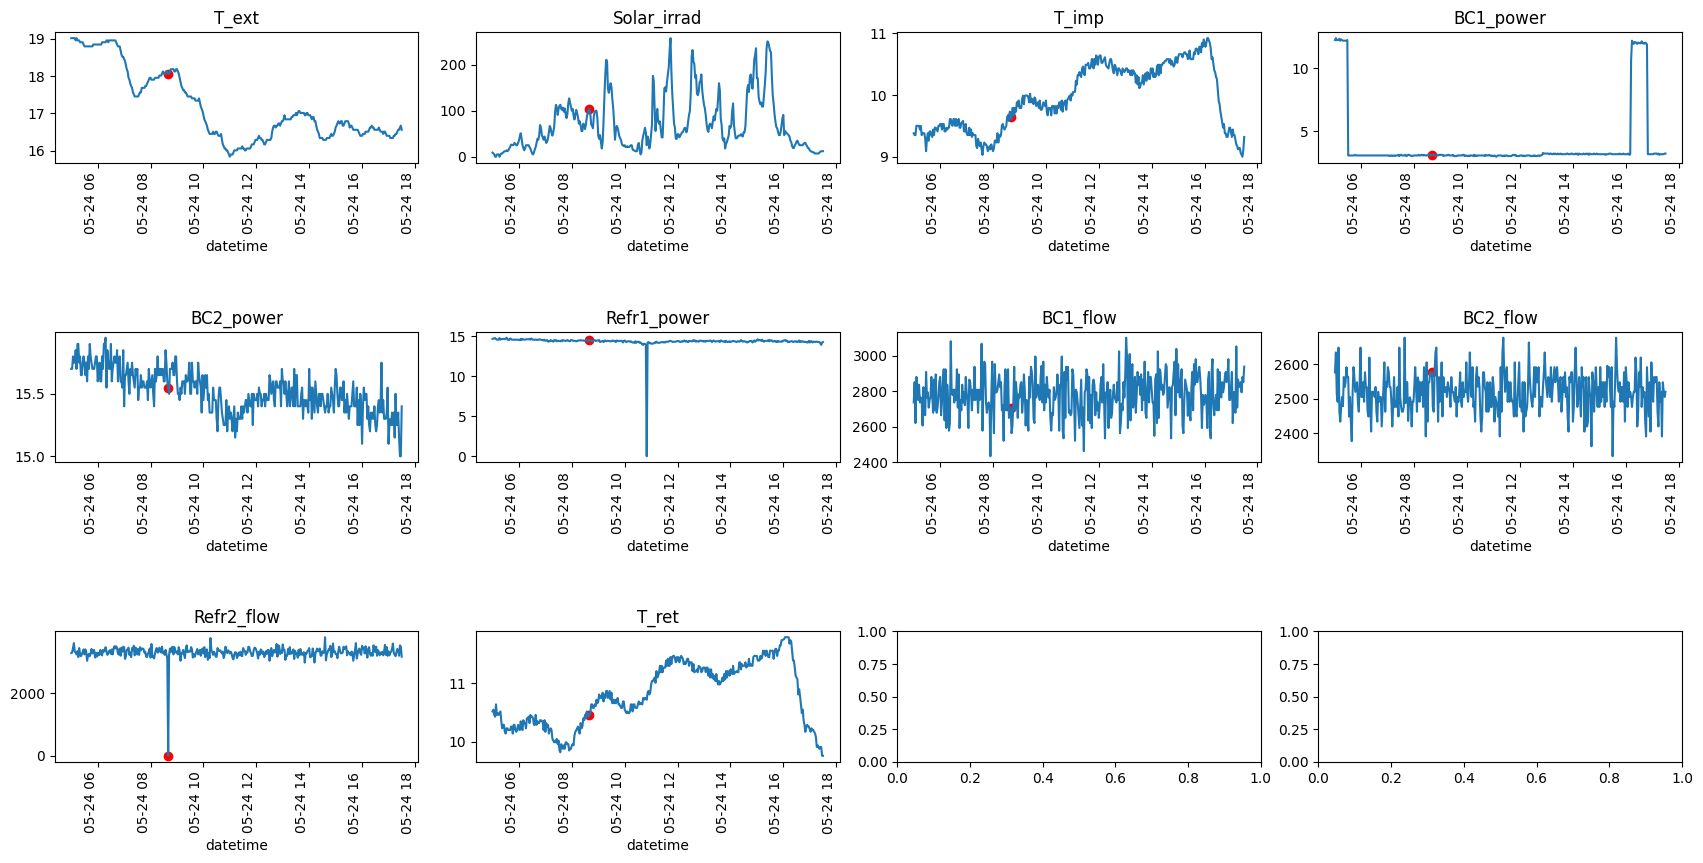

In [21]:
import matplotlib.pyplot as plt

# Your existing setup
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(17, 10))
fig.tight_layout(rect=[0, 0.70, 1, 0.95])
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(all_columns):
    df_day[[col]].plot(ax=axes[i], legend=False, title=col, x_compat=True, rot=90)
    
    # Check if the specific_datetime is in the index
    if full_date in df_day.index:
        # Extract the value for the specific datetime
        value = df_day.loc[full_date, col]

        # Plot the red dot
        axes[i].scatter(full_date, value, color='red')

plt.show()